<h2>Importing Data<h2>

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from helper import plot_x_days


In [118]:
df1 = pd.read_json('./Datasets/generated_data_Economics.json')
df2 = pd.read_csv('./Datasets/VOO.csv')
df2.head()

,Unnamed: 0,Adj Close
0,2022-08-29 09:30:00-04:00,369.648010
1,2022-08-29 09:31:00-04:00,369.799988
2,2022-08-29 09:33:00-04:00,370.220001
3,2022-08-29 09:34:00-04:00,370.549988
4,2022-08-29 09:35:00-04:00,370.299988


<h3>Preparing The Stock Price Data<h3>

In [119]:
df2['date_time'] = pd.to_datetime(df2['Unnamed: 0'])
df2['date'] = df2['date_time'].dt.date
df2['time'] = df2['date_time'].dt.time
df2.rename(columns={'Adj Close': 'price'}, inplace=True)
df2.head(5)


,Unnamed: 0,price,date_time,date,time
0,2022-08-29 09:30:00-04:00,369.648010,2022-08-29 09:30:00-04:00,2022-08-29,09:30:00
1,2022-08-29 09:31:00-04:00,369.799988,2022-08-29 09:31:00-04:00,2022-08-29,09:31:00
2,2022-08-29 09:33:00-04:00,370.220001,2022-08-29 09:33:00-04:00,2022-08-29,09:33:00
3,2022-08-29 09:34:00-04:00,370.549988,2022-08-29 09:34:00-04:00,2022-08-29,09:34:00
4,2022-08-29 09:35:00-04:00,370.299988,2022-08-29 09:35:00-04:00,2022-08-29,09:35:00


In [120]:
df2 = df2[['date', 'time', 'price']]
df2 = df2.groupby('date').agg(list)
df2['time_price'] = df2.apply(lambda row : dict(zip(row[0],row[1])), axis=1)
df2['na'] = np.nan
df2.reset_index(inplace=True)
df2.head()

,date,time,price,time_price,na
0,2022-08-29,"[09:30:00, 09:31:00, 09:33:00, 09:34:00, 09:35...","[369.6480102539063, 369.7999877929688, 370.220...","{09:30:00: 369.6480102539063, 09:31:00: 369.79...",NaN
1,2022-08-30,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[371.2200012207031, 370.760009765625, 371.0400...","{09:30:00: 371.2200012207031, 09:31:00: 370.76...",NaN
2,2022-08-31,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.0400085449219, 367.0700073242188, 366.660...","{09:30:00: 367.0400085449219, 09:31:00: 367.07...",NaN
3,2022-09-01,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[361.5299987792969, 360.8349914550781, 360.959...","{09:30:00: 361.5299987792969, 09:31:00: 360.83...",NaN
4,2022-09-02,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.3999938964844, 366.8800048828125, 366.709...","{09:30:00: 367.3999938964844, 09:31:00: 366.88...",NaN


In [121]:
#generate daily data
def generate_daily_data(index):
    #create a data frame of all possible minute values in a day
    d = df2.iloc[index][['date', 'na']].to_dict()
    d['time'] = pd.date_range(df2['date'].iat[index], freq='Min', periods=60*24, name='date')
    df = pd.DataFrame(d)
    df.set_index(df['time'].dt.time, inplace = True)
    df = df[['na']]

    #create dataframe of stock prices
    price_time_df = pd.DataFrame(df2.iloc[index]['price'], index =  df2.iloc[index]['time'], columns=['price'])

    joined_df = df.join(price_time_df)

generate_daily_data(0)

          na       price
time                    
00:00:00 NaN         NaN
00:01:00 NaN         NaN
00:02:00 NaN         NaN
00:03:00 NaN         NaN
00:04:00 NaN         NaN
...       ..         ...
13:15:00 NaN  371.880005
13:16:00 NaN  371.619995
13:17:00 NaN  371.500000
13:18:00 NaN  371.299988
13:19:00 NaN  371.420013

[800 rows x 2 columns]
               price
09:30:00  369.648010
09:31:00  369.799988
09:33:00  370.220001
09:34:00  370.549988
09:35:00  370.299988
...              ...
12:47:00  371.640015
12:48:00  372.005005
12:49:00  372.000092
12:50:00  372.179993
12:51:00  372.339996

[200 rows x 1 columns]


<h3>Merging The Sentiment Data And Stock Price Data<h3>

In [122]:
df1.reset_index(inplace=True)
df1.rename(columns={'index': 'date'}, inplace=True)
df1.head()

,date,Economics
0,2022-08-30,"{'10:58:00': {'polarity': 0.0, 'subjectivity':..."
1,2022-08-31,"{'00:00:00': {'polarity': 0.0, 'subjectivity':..."
2,2022-09-01,"{'00:18:00': {'polarity': 0.0, 'subjectivity':..."
3,2022-09-02,"{'00:01:00': {'polarity': 0.8, 'subjectivity':..."
4,2022-09-03,"{'00:02:00': {'polarity': 0.0, 'subjectivity':..."


In [123]:
df = pd.merge(df1, df2, how='outer', on='date')
df['date'] =  pd.to_datetime(df['date'])
df.dropna(inplace=True)
df.head()

ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

<h3>Determining Percent Change In Price<h3>

In [ ]:
def generate_price_dif(row):
    prices = np.asarray(row['price'])
    price_shift = np.asarray(row['price'][1:] + row['price'][0:1])
    delta_price = prices-price_shift
    percent_change = delta_price/prices
    return delta_price

df['price_diff']  = df.apply(lambda row: generate_price_dif(row), axis=1)
df['percent_change'] = df.apply(lambda row: (row['price_diff']/np.asarray(row['price'])) * 100, axis= 1)
df.head()

ValueError: Expected a 1D array, got an array with shape (0, 6)

In [ ]:
def generate_day_data(row):
    df = pd.DataFrame(list(row['time_price']), index=row['date'])
    
    return df
print(generate_day_data(df.iloc[0]))

TypeError: Index(...) must be called with a collection of some kind, Timestamp('2022-08-30 00:00:00') was passed

<h2>Visualizing Trends In News Sentiment and Stock Prices</h2>

<p>Visualizing the data should reveal trends in the prices that make be unintuitive given large sets of numbers. This should provide us with a solid basis for attempting to explore correlations in stock prices and news sentiment.</p>

<h3>Plotting Sentiment Versus Price</h3>

<p>We begin by exploring the intesnity of sentiment per minute with data to the daily graph of our given stock.</p>

In [ ]:

def get_data_day(x, dataframe, row):
    lst = []
    for i in range(x):
        lst += dataframe.iloc[i][row]
    return lst

def get_time_data_day(x, dataframe):
    times = []
    for i in range(x):
        date = dataframe.iloc[i]['date']
        for item in dataframe.iloc[i]['time']:
            time = item.split(":")
            times.append(datetime.datetime(date.year,date.month,date.day,int(time[0]),int(time[1])))
    return times

def plot_x_days_price(x, dataframe, subplot = plt):
    lst = get_data_day(x, dataframe, 'price')
    times = get_time_data_day(x, dataframe)
    subplot.plot(times, lst)


def plot_x_days_sentiment(x, subreddit, dataframe, data_gather, subplot = plt):
    dct_lst = {}
    for point in data_gather.keys():
        dct_lst[f'{point}'] = np.array(
            [dataframe.iloc[i][subreddit][key][point] for i in range(x) for key in dataframe.iloc[i][subreddit]]).astype(float)
        dct_lst[f'{point}'][f'{point}_list'==0] = np.nan
    #times = get_time_data_day(x, dataframe)
    times = []
    for i in range(x):
        date = dataframe.iloc[i]['date']
        for item in dataframe.iloc[i][subreddit].keys():
            time = item.split(":")
            times.append(datetime.datetime(date.year,date.month,date.day,int(time[0]),int(time[1])))

    for key, lst in dct_lst.items():
        subplot.bar(times, lst, color = data_gather[key], width=.005)
        subplot.bar(times, lst, color = data_gather[key], width=.005)

def plot_x_days(x, subreddit, dataframe):
    figure, axis = plt.subplots(2,1)
    plot_x_days_sentiment(x, subreddit, dataframe, {'neg': 'red','pos':'green'},axis[0])
    plot_x_days_price(x, dataframe, axis[1])
    #plot_change(1, dataframe, axis[0])


def generate_day_frame(row, subreddit):
    df = pd.DataFrame.from_dict(row[subreddit], orient='index')
    return df


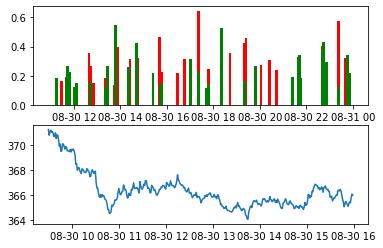

In [ ]:
plot_x_days(1,'Economics', df)

<p>Now lets explore the relationship between change in price and the sentiment intensities</p>

In [ ]:

def plot_change(x, dataframe, subplot = plt):
    lst = []
    times = []
    for i in range(x):
        date = dataframe.iloc[i]['date']
        for item in dataframe.iloc[i]['time']:
            time = item.split(":")
            times.append(datetime.datetime(date.year,date.month,date.day,int(time[0]),int(time[1])))
        lst += list(dataframe.iloc[i]['percent_change'])

    subplot.plot(times, lst)
    #subplot.ylim(-.3, 1)

<h3>Initial Hypothesis</h3>
<p>blah blah blah</p>

<h2>Markov Chains<h2>

<h3>Nth Degree Markov Chains<h3>

<h3>Optimizing Nth Degree Markov Chains<h3>

<h2>Deep Neural Network<h2>

<h2>LSTM Networks<h2>